In [1]:
import pickle
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from theano import shared

import matplotlib.pyplot as pl
from matplotlib import rcParams
import arviz as ar
from seaborn import heatmap
from cmocean.cm import balance_r

In [2]:
display(HTML("<style>.container {width: 94% !important}</style>"))

In [3]:
with open('./PickleJar/mab_train_dict.pkl', 'rb') as f_train:
    train_dict = pickle.load(f_train)

In [4]:
x_train = train_dict['original_x']
x_train_s = train_dict['stdized_x']
y_train = train_dict['y']
scaler = train_dict['scaler']

####  First Model

In [5]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
month,991.0,7.313824,2.522505,2.000000e+00,6.000000,7.000000,8.000000,11.000000
lat,991.0,40.395538,2.050631,3.574517e+01,39.016300,40.637602,42.060422,44.233183
lon,991.0,-71.082693,3.084383,-7.606900e+01,-73.897138,-70.602558,-68.363850,-65.436767
lob_bat_dep,991.0,1.825134,0.429198,3.010302e-01,1.496007,1.832509,2.143015,3.676694
log_dep,991.0,0.669670,1.155061,-6.000000e+00,0.307496,0.477121,1.316599,2.741254
Wt,991.0,13.808893,5.565119,1.000000e-10,10.056350,13.046413,16.530000,27.418000
Sal,991.0,31.907795,2.486935,4.980300e-01,31.429000,32.259600,32.782750,36.724800
ag412,991.0,0.164124,0.096510,2.390129e-02,0.109528,0.140498,0.190612,0.873652
S275:295,991.0,0.025632,0.002972,1.611367e-02,0.023883,0.025530,0.027088,0.041245


In [6]:
x_train_s['log_ag412'] = np.log10(x_train.ag412)
y_train_log = np.log10(y_train)

In [29]:
features = ['lob_bat_dep', 'Wt', 'Sal']
X_shared = shared(x_train_s[features].values)

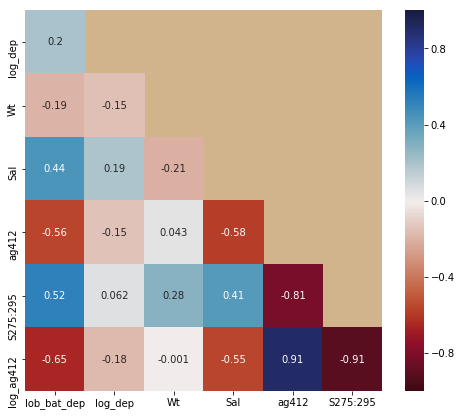

In [18]:
_, ax = pl.subplots(figsize=(8, 7))
heatmap(x_train_s.loc[:, 'lob_bat_dep':].corr().iloc[1:, :-1], vmin=-1, vmax=1, annot=True, cmap=balance_r,
       mask=np.triu(np.ones([6]*2), k=1)
       )
ax.set_facecolor('tan')

In [43]:
x_train_s[features].describe().T

,count,mean,std,min,25%,50%,75%,max
Wt,991.0,-6.849269e-17,1.000505,-2.482582,-0.674637,-0.137080,0.489204,2.446664
Sal,991.0,-1.078966e-15,1.000505,-12.636285,-0.192621,0.141533,0.351998,1.937902
ag412,991.0,1.055328e-16,1.000505,-1.453675,-0.565987,-0.244933,0.274594,7.355599


In [44]:
y_train_s = (y_train-y_train.mean())/ y_train.std()

In [30]:
with pm.Model() as m1:
    alpha = pm.Normal('alpha', mu=0, sd=10,)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(features))
    
    sd_data = pm.HalfCauchy('sd_data', beta=5)
    
    mu_lkl = pm.Deterministic('mu_lkl', alpha + tt.dot(X_shared, beta))
    likelihood = pm.Normal('likelihood', mu=mu_lkl, sd=sd_data, observed=y_train_log.values)

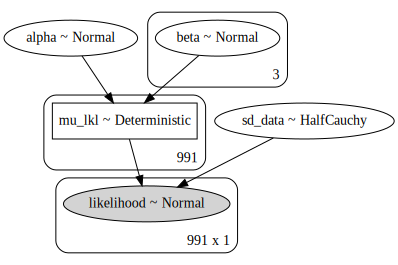

In [31]:
pm.model_to_graphviz(m1)

In [32]:
with m1:
    prior = pm.sample_prior_predictive()    

In [ ]:
with m1:
    m1_trace = pm.sample(tune=1500, sample=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_data, beta, alpha]
Sampling 4 chains:  14%|█▍        | 1134/8000 [01:42<25:25,  4.50draws/s]

In [31]:
with m1:
    posterior_predictive_m1 = pm.sample_ppc(m1_trace)

100%|██████████| 500/500 [00:00<00:00, 643.87it/s]


/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


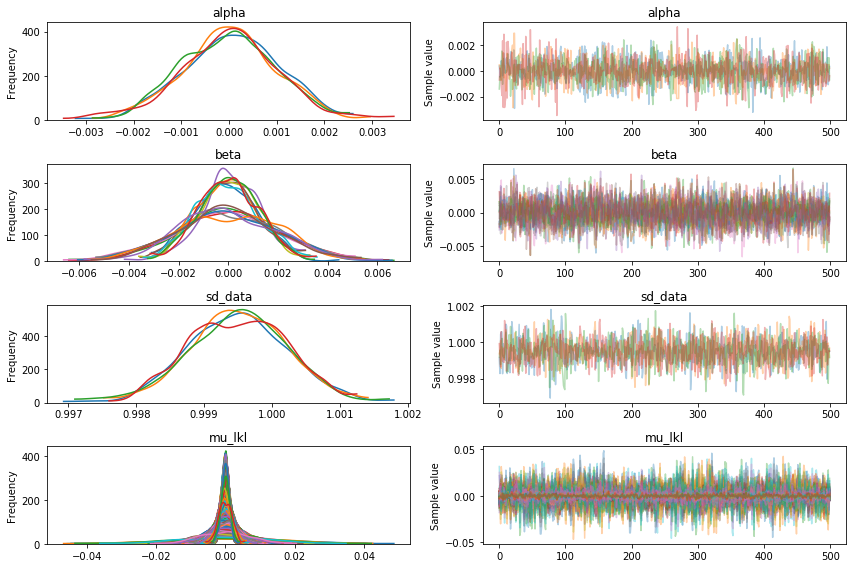

In [35]:
pm.traceplot(m1_trace);

In [34]:
data = ar.from_pymc3(trace=m1_trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive_m1,
                     )
data

MemoryError: 